### Load packages

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals, rms
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib
import numpy as np
#import nglview as nv
import pandas as pd
import math
import seaborn as sns
import os

### Set variables

In [2]:
is_deactivate_warning = True
is_savefigs = True
is_makemovie = False
is_makemovie_from_disk = False

sysname = 'AlanineDipeptide'

root_dir = '.' #'/home/numerik/bzfzhang/work/projects/numerical_data/ongoing/MDTrajectories/alanine-dipeptide/gromacs'

# directory containing trajectory data
#work_name = 'water-abf-500ns'
work_name = '' #water-1500ns-1'

work_path = '%s/%s' % (root_dir, work_name)

run_prefix_list = ['nvt', 'npt', 'md']
top_prefix_list = ['top', 'top', 'top']

run_id = 2

top_prefix = top_prefix_list[run_id]
run_prefix = run_prefix_list[run_id]

# name of topology file
topology_filename = '%s/%s.gro' % (work_path, top_prefix)
# name of trajectory file
traj_filename = '%s/%s.trr' % (work_path, run_prefix)

if not os.path.exists(traj_filename):
    traj_filename = '%s/%s.xtc' % (work_path, run_prefix)

if not os.path.exists(traj_filename):
    traj_filename = None
    print ('Warning: could not find trajectory data!')
    
if is_deactivate_warning :
    import warnings
    warnings.filterwarnings("ignore")    

out_path = './%s/' % work_name
if not os.path.exists(out_path) :
    os.makedirs(out_path)
        
if is_makemovie :
    import moviepy.editor as mpy
    from time import sleep
    # display the gif in this notebook
    from IPython import display

In [14]:
gmx_cmd = '~/local/gromacs-2021.6/bin/gmx'

tpr_file = "%s/md.tpr" % (work_path)
traj_filename_center = '%s/md_center.xtc' % (out_path)

!printf "1\n1\n" | {gmx_cmd} trjconv -s {tpr_file} -f {traj_filename} -o {traj_filename_center} -center -pbc mol -ur compact

            :-) GROMACS - gmx trjconv, 2021.6-Colvars-2023-07-18 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff          

## load trajectory 

In [15]:
# load trajectory data 
u = mda.Universe(topology_filename, traj_filename_center)

print ('Number of residues: %d' % len(u.residues))

for res_id in range(len(u.residues)):
    res = u.residues[res_id]
    atom_selected = res.phi_selection()
    if atom_selected is not None:
        df = pd.DataFrame(list(zip(atom_selected.ids, atom_selected.names, atom_selected.types)), columns = ['id', 'name', 'type'])
        print ('residual %d, phi dihedral angle:' % (res_id+1) )
        print (df, '\n')
    atom_selected = res.psi_selection()
    if atom_selected is not None:
        df = pd.DataFrame(list(zip(atom_selected.ids, atom_selected.names, atom_selected.types)), columns = ['id', 'name', 'type'])
        print ('residual %d, psi dihedral angle:' % (res_id+1) )
        print (df, '\n')
        
# load reference configuration from the topology file
ref = mda.Universe(topology_filename) 

time_list = np.linspace(u.trajectory.time, u.trajectory.totaltime, u.trajectory.n_frames) * 1e-3

# print some information
print ('%d residues: ' % len(u.residues), u.residues, '\n')
print ('trajectory: ', u.trajectory, '\n')
print ('time of trajectory (in ps) , range [%.1f, %.1f], dt=%.1f\n' % (u.trajectory.time, u.trajectory.totaltime, u.trajectory.dt))

print ('reference:', ref.trajectory)
# display the trajectory
#view = nv.show_mdanalysis(u)
#print ('number of frames: %d ' % view.max_frame)
#view

Number of residues: 3
residual 2, phi dihedral angle:
   id name type
0   5    C    C
1   7    N    N
2   9   CA    C
3  15    C    C 

residual 2, psi dihedral angle:
   id name type
0   7    N    N
1   9   CA    C
2  15    C    C
3  17    N    N 

3 residues:  <ResidueGroup [<Residue ACE, 1>, <Residue ALA, 2>, <Residue NME, 3>]> 

trajectory:  <XTCReader .///md_center.xtc with 6 frames of 22 atoms> 

time of trajectory (in ps) , range [0.0, 50.0], dt=10.0

reference: <GROReader .//top.gro with 1 frames of 22 atoms>


### Generate plots of two dihedral angles

In [16]:
selector = 'resid 2'
atom_selected = u.select_atoms(selector)

df = pd.DataFrame(list(zip(atom_selected.ids, atom_selected.names, atom_selected.types)), columns = ['id', 'name', 'type'])

print ('%d selected atoms:' % len(atom_selected))
print (df, '\n')

r = dihedrals.Ramachandran(atom_selected).run()
#ax = plt.gca()
#r.plot(ax, color='black', marker='.') #, ref=True)

cv_names = ['phi', 'psi']
dihedrals_df = pd.DataFrame(r.angles[:,0,:], columns=cv_names)
dihedrals_df['t'] = time_list

print ('dihedral angles:\n', dihedrals_df.describe())

traj_angles = r.angles[:,0,:]

10 selected atoms:
   id name type
0   7    N    N
1   8    H    H
2   9   CA    C
3  10   HA    H
4  11   CB    C
5  12  HB1    H
6  13  HB2    H
7  14  HB3    H
8  15    C    C
9  16    O    O 

dihedral angles:
               phi         psi         t
count    6.000000    6.000000  6.000000
mean  -128.956028   66.795460  0.025000
std     31.539475   71.375221  0.018708
min   -160.744585  -12.968551  0.000000
25%   -141.435135   15.786929  0.012500
50%   -137.668398   50.174730  0.025000
75%   -129.102953  120.646062  0.037500
max    -68.716267  164.931019  0.050000


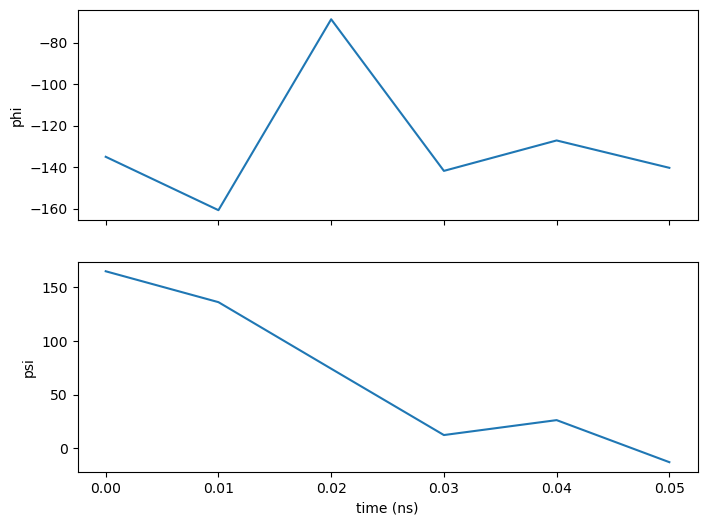

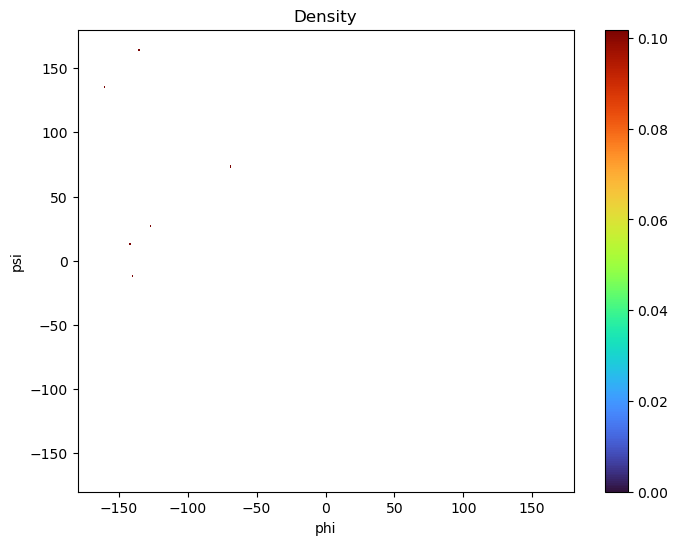

In [17]:
f, axarr = plt.subplots(2, figsize=(8,6), sharex=True)
sns.lineplot(dihedrals_df, x='t', y=cv_names[0], ax=axarr[0])
sns.lineplot(dihedrals_df, x='t', y=cv_names[1], ax=axarr[1])
axarr[1].set_xlabel('time (ns)')
plt.show()

if is_savefigs :
    f.savefig('%s/%s_traj_cv.png' % (out_path, run_prefix))
    
plt.figure(figsize=(8,6))   
#dis_pd = pd.DataFrame([res_dist_1, res_dist_2])
#sns.scatterplot(data=dis_pd, x='d3-7', y='d3-8')
sns.histplot(data=dihedrals_df, x=cv_names[0], y=cv_names[1], cbar=True, stat='density', cmap='turbo', bins=(100,100))
plt.title('Density')
plt.xlim(-180, 180)
plt.ylim(-180, 180)

if is_savefigs :
    plt.savefig('%s/%s_hist2d_cv.png' % (out_path, run_prefix))

RMSD, based on 7 selected atoms:
   id name type
0   5    C    C
1   6    O    O
2   7    N    N
3   9   CA    C
4  15    C    C
5  16    O    O
6  17    N    N 



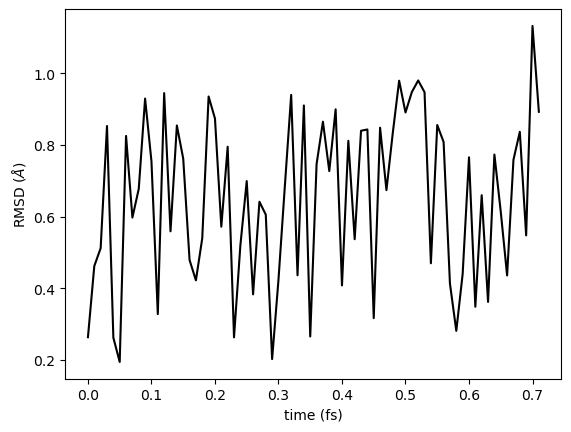

RMSF:
    id name type      RMSF
0   5    C    C  2.180647
1   6    O    O  2.629561
2   7    N    N  1.400910
3   9   CA    C  1.051400
4  15    C    C  1.168909
5  16    O    O  1.850256
6  17    N    N  2.083853


NameError: name 'fig_path' is not defined

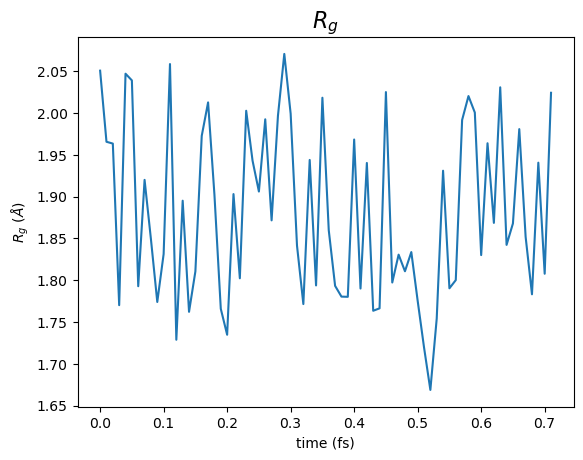

In [9]:
# select atoms for RMSD, RMSF, Radius of Gyration computations below 
selector = 'name N or name CA or name C or name O'
#selector = 'protein'

atom_selected = u.select_atoms(selector)
df = pd.DataFrame(list(zip(atom_selected.ids, atom_selected.names, atom_selected.types)), columns = ['id', 'name', 'type'])

print ('RMSD, based on %d selected atoms:' % len(atom_selected))
print (df, '\n')

# compute RMSD of the trajectory wrt the reference configuration
rmsd_arr = [rms.rmsd(u.select_atoms(selector).positions, ref.select_atoms(selector).positions, center=True, superposition=True) for ts in u.trajectory[:]]

#R = rms.RMSD(u, ref, select=selector,center=True, superposition=True)          
#R.run()
# get the RMSD result
#rmsd = R.results.rmsd.T   # transpose makes it easier for plotting

plt.plot(time_list, rmsd_arr, 'k-')
plt.xlabel("time (fs)")
plt.ylabel(r"RMSD ($\AA$)")

plt.show()

rmsf_arr = rms.RMSF(atom_selected).run()
df['RMSF'] = rmsf_arr.results.rmsf
print ('RMSF:\n', df)

# Compute Radius of Gyration

rgyr_arr = []
for ts in u.trajectory:
    rgyr_arr.append(atom_selected.radius_of_gyration())
    
plt.plot(time_list, rgyr_arr)
plt.title("$R_{g}$",fontsize=16)
plt.xlabel("time (fs)")
plt.ylabel(r"$R_{g}$ ($\AA$)")

if is_savefigs :
    fig_filename_rmsd = '%s/%s_rmsd.eps' % (fig_path, run_prefix) 
    plt.savefig(fig_filename_rmsd)    
    print ('\nRMSD plot saved to file: %s' % fig_filename_rmsd)
    

### plot energy

In [10]:
gmx_cmd = 'gmx'
quantity_list = ['Potential', 'Temperature', 'Total-Energy', 'Kinetic-En.']
quantity_id = 1
quantity_name = quantity_list[quantity_id]

edr_file = "%s/%s.edr" % (work_path, run_prefix)

output_file = '%s/%s.xvg' % (fig_path, quantity_name)

!printf "{quantity_name}\n0\n" |  {gmx_cmd} energy -f {edr_file} -o {output_file} -xvg none

NameError: name 'fig_path' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv(output_file, sep='\s+', header=None, names=['time', quantity_name])
df.plot('time')

ncv= 2
[-3.3, 0.1, 66.0, 0.0] [-3.3, 0.1, 66.0, 0.0]
ncv= 2
[-3.3, 0.1, 66.0, 0.0] [-3.3, 0.1, 66.0, 0.0]
ncv= 2
[-3.35, 0.1, 67.0, 0.0] [-3.35, 0.1, 67.0, 0.0]
ncv= 2
[-3.35, 0.1, 67.0, 0.0] [-3.35, 0.1, 67.0, 0.0]


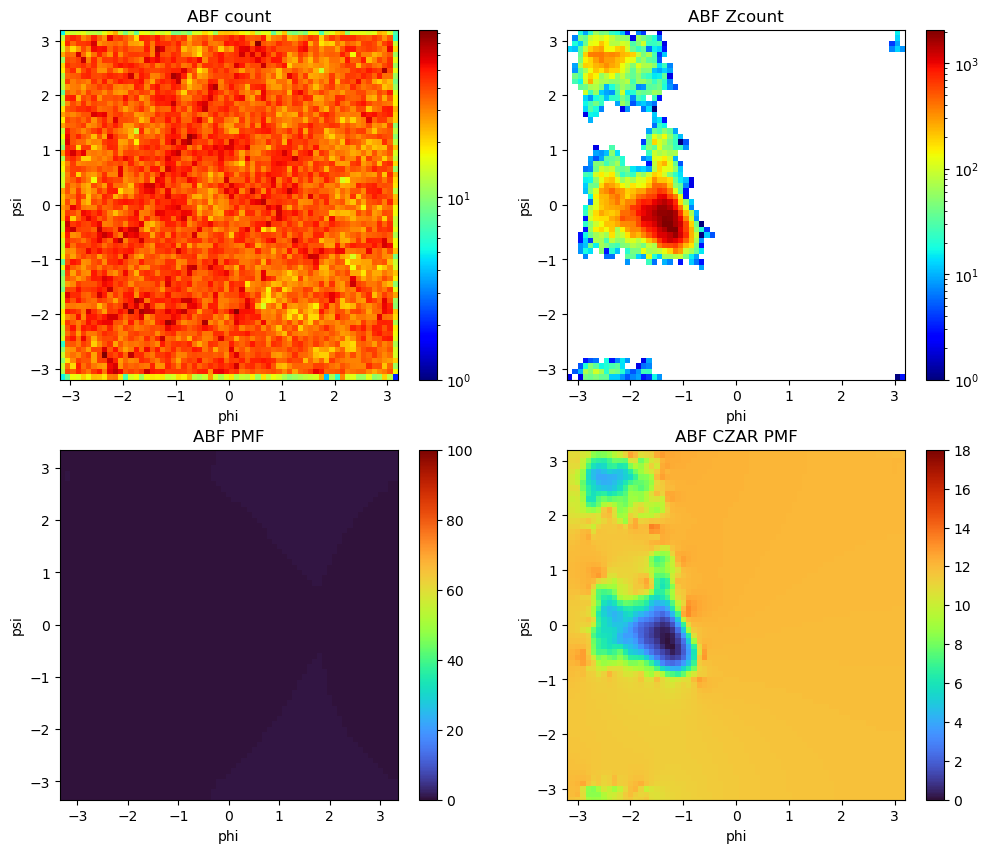

In [21]:
def plot_abf(filename, ax, vmax=-1, log_scale=False, cmap=mpl.cm.jet, cnorm=None):
    file = open(filename, 'r')
    line = file.readline()
    ncv = int (line.split()[1])
    print ('ncv=', ncv)

    line = file.readline()
    cv1 = [float (x) for x in line.split()[1:]]
    n1 = int (cv1[2]) 
    line = file.readline()
    cv2 = [float (x) for x in line.split()[1:]]
    n2 = int (cv2[2])
    print (cv1, cv2)
    file.close()
    raw_data = np.loadtxt(filename)
    if vmax < 0 :
        vmax = raw_data[:,2].max()    
    if cnorm is None :    
        if log_scale == False :      
            cnorm = colors.Normalize(0, vmax)
        else :
            cnorm = colors.LogNorm(1, vmax)                        
    im = ax.pcolormesh(raw_data[:,0].reshape(n1, n2), raw_data[:,1].reshape(n1,n2), raw_data[:,2].reshape(n1, n2), norm=cnorm, cmap=cmap)        

    return im

fig, ax = plt.subplots(2,2, figsize=(12, 10))
xlim=[-3.2, 3.2]
ylim=[-3.2, 3.2]
abf_path = work_path
im = plot_abf('%s/%s.count' % (abf_path, run_prefix), ax[0][0], -1, True)
ax[0][0].set_title('ABF count')
ax[0][0].set_xlabel(cv_names[0])
ax[0][0].set_ylabel(cv_names[1])
fig.colorbar(im, ax=ax[0][0])
ax[0][0].set_xlim(xlim[0], xlim[1])
ax[0][0].set_ylim(xlim[0], xlim[1])

im = plot_abf('%s/%s.zcount' % (abf_path, run_prefix), ax[0][1], -1, True)
ax[0][1].set_title('ABF Zcount')
ax[0][1].set_xlabel(cv_names[0])
ax[0][1].set_ylabel(cv_names[1])
fig.colorbar(im, ax=ax[0][1])
ax[0][1].set_xlim(xlim[0], xlim[1])
ax[0][1].set_ylim(xlim[0], xlim[1])

cmap = mpl.cm.turbo
bounds=[0,2,4,6,8,10,12,14]
cnorm = colors.BoundaryNorm(bounds, cmap.N) 
im = plot_abf('%s/%s.pmf' % (abf_path, run_prefix), ax[1][0], 100, False, cmap, cnorm=None)
ax[1][0].set_title('ABF PMF')
ax[1][0].set_xlabel(cv_names[0])
ax[1][0].set_ylabel(cv_names[1])
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
fig.colorbar(im, ax=ax[1][0])

cmap = mpl.cm.turbo
bounds=[0,2,4,6,8,10,12,14]
cnorm = colors.BoundaryNorm(bounds, cmap.N) 

im = plot_abf('%s/%s.czar.pmf' % (abf_path, run_prefix), ax[1][1], 18, False, cmap, cnorm=None)
ax[1][1].set_title('ABF CZAR PMF')
ax[1][1].set_xlabel(cv_names[0])
ax[1][1].set_ylabel(cv_names[1])
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
fig.colorbar(im, ax=ax[1][1])



ncv= 2
[-3.35, 0.1, 67.0, 0.0] [-3.35, 0.1, 67.0, 0.0]
ncv= 2
[-3.35, 0.1, 67.0, 0.0] [-3.35, 0.1, 67.0, 0.0]


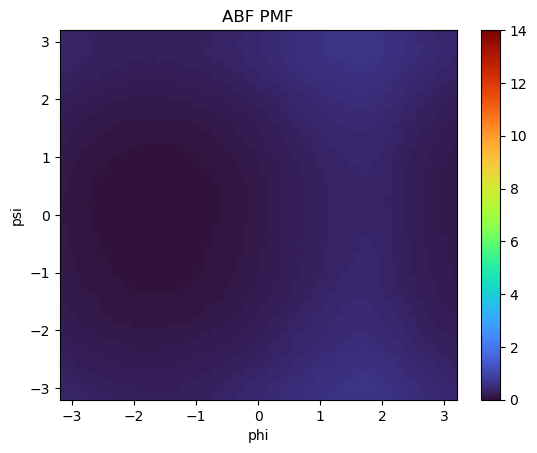

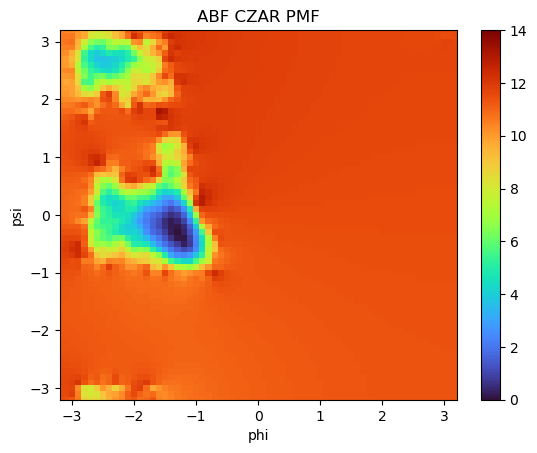

In [20]:
fig, ax = plt.subplots()
cmap = mpl.cm.turbo
bounds=[0,2,4,6,8,10,12,14]
cnorm = colors.BoundaryNorm(bounds, cmap.N) 
im = plot_abf('%s/%s.pmf' % (abf_path, run_prefix), ax, 14, False, cmap, cnorm=None)
ax.set_title('ABF PMF')
ax.set_xlabel(cv_names[0])
ax.set_ylabel(cv_names[1])
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
fig.colorbar(im, ax=ax)

if is_savefigs:
    fig.savefig('%s/%s_pmf.png' % (out_path, run_prefix))
    
fig, ax = plt.subplots()
cmap = mpl.cm.turbo
bounds=[0,2,4,6,8,10,12,14]
cnorm = colors.BoundaryNorm(bounds, cmap.N) 
im = plot_abf('%s/%s.czar.pmf' % (abf_path, run_prefix), ax, 14, False, cmap, cnorm=None)
ax.set_title('ABF CZAR PMF')
ax.set_xlabel(cv_names[0])
ax.set_ylabel(cv_names[1])
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
fig.colorbar(im, ax=ax)

if is_savefigs:
    fig.savefig('%s/%s_czar_pmf.png' % (out_path, run_prefix))    